# Système de recommandation hybride basé sur la similarité des utilisateurs, la similarité du contenu et l'analyse des sentiments

In [1]:
import os
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer



# --- Chargement ou génération des données
users_file = "users.csv"
products_file = "products.csv"
user_likes_file = "user_likes.csv"
comments_file = "comments.csv"

# Création des jeux de données simulés
if os.path.exists(users_file) and os.path.exists(products_file) and os.path.exists(user_likes_file):
    users = pd.read_csv(users_file)
    products = pd.read_csv(products_file)
    user_likes = pd.read_csv(user_likes_file)
else:
    user_count = 5
    product_count = 5
    likes_per_user = (3, 5)

    users = pd.DataFrame({
        "user_id": range(1, user_count + 1),
        "username": [f"user{i}" for i in range(1, user_count + 1)],
        "email": [f"user{i}@example.com" for i in range(1, user_count + 1)]
    })

    products = pd.DataFrame({
        "product_id": range(1, product_count + 1),
        "name": [f"Produit {i}" for i in range(1, product_count + 1)],
        "category": [random.choice(["Électronique", "Livres", "Mode", "Accessoires"]) for _ in range(product_count)],
        "description": [f"Description du produit {i}" for i in range(1, product_count + 1)]
    })

    likes_data = []
    for user_id in users["user_id"]:
        liked_products = random.sample(range(1, product_count + 1), random.randint(*likes_per_user))
        for product_id in liked_products:
            likes_data.append((user_id, product_id, True))

    user_likes = pd.DataFrame(likes_data, columns=["user_id", "product_id", "liked"])
    users.to_csv(users_file, index=False)
    products.to_csv(products_file, index=False)
    user_likes.to_csv(user_likes_file, index=False)

# --- Génération ou chargement des commentaires
if os.path.exists(comments_file):
    comments = pd.read_csv(comments_file)
else:
    sentiments = ["I love this product!", "Not great.", "Pretty decent", "Terrible quality.", "Amazing!", "Not bad", "Excellent!", "Would not recommend.", "Best purchase ever!", "Disappointed."]
    comments_data = []

    for _, row in user_likes.iterrows():
        if random.random() < 0.5:
            comment = random.choice(sentiments)
            comments_data.append((row["user_id"], row["product_id"], comment))

    comments = pd.DataFrame(comments_data, columns=["user_id", "product_id", "comment"])
    comments.to_csv(comments_file, index=False)

# Analyse de sentiment
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

comments["sentiment_score"] = comments["comment"].apply(get_sentiment)
avg_sentiment_per_product = comments.groupby("product_id")["sentiment_score"].mean().reset_index()
avg_sentiment_per_product.columns = ["product_id", "avg_sentiment"]

# Matrice utilisateur-produit
user_item_matrix = user_likes.pivot_table(index="user_id", columns="product_id", values="liked", fill_value=0)
#print(user_likes)
#print(user_item_matrix)
# Modèle KNN basé utilisateur
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

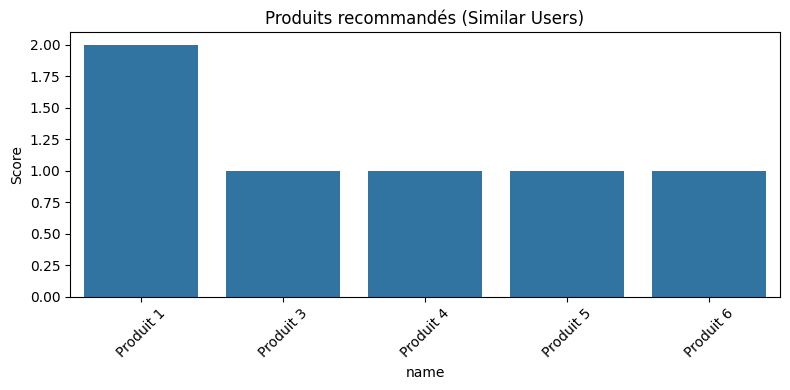

,product_id,name,category
0,1,Produit 1,Électronique
1,3,Produit 3,Mode
2,4,Produit 4,Accessoires
3,5,Produit 5,Accessoires
4,6,Produit 6,Accessoires


In [2]:
# Recommandation basée sur utilisateurs similaires
def recommend_by_similar_users(user_id, n_neighbors=3):
    user_index = user_id - 1
    distances, indices = knn.kneighbors([user_item_matrix.iloc[user_index]], n_neighbors=n_neighbors+1)
    similar_users = user_item_matrix.iloc[indices[0][1:]]
    liked_by_similar = similar_users.sum().sort_values(ascending=False)
    already_liked = user_item_matrix.loc[user_id]
    not_yet_liked = liked_by_similar[already_liked[already_liked == 0].index]
    return not_yet_liked
    
    # Limit the number of recommendations to top_n
    return recommended_items[:top_n]


# Calcul des recommandations users
final_recommendations1 = recommend_by_similar_users(user_id=1).sort_values(ascending=False).head(20)
recommended_products1 = products[products["product_id"].isin(final_recommendations1.index)][["product_id", "name", "category"]]
recommended_products1 = recommended_products1.set_index("product_id").loc[final_recommendations1.index].reset_index()

# Visualisation
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended_products1["name"], y=final_recommendations1.values)
plt.title("Produits recommandés (Similar Users)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

recommended_products1

[2]


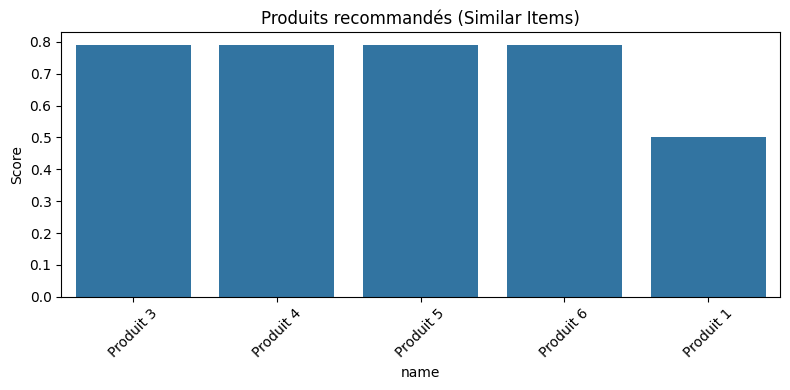

,product_id,name,category
0,3,Produit 3,Mode
1,4,Produit 4,Accessoires
2,5,Produit 5,Accessoires
3,6,Produit 6,Accessoires
4,1,Produit 1,Électronique


In [3]:
# Recommandation basée sur produits similaires
item_similarity_matrix = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def recommend_by_similar_items(user_id):
    user_ratings = user_item_matrix.loc[user_id]
    liked_items = user_ratings[user_ratings == 1].index.tolist()
    print(liked_items)
    # Calculer les scores de similarité entre les produits appréciés par l'utilisateur
    item_scores = item_similarity_df[liked_items].sum(axis=1)
    #print(item_scores)
    # Exclure les produits que l'utilisateur a déjà aimés
    item_scores = item_scores.drop(index=liked_items, errors='ignore')
    #print(item_scores)
    return item_scores

# Calcul des recommandations hybrides
final_recommendations2 = recommend_by_similar_items(user_id=1).sort_values(ascending=False).head(20)
recommended_products2 = products[products["product_id"].isin(final_recommendations2.index)][["product_id", "name", "category"]]
# Réordonner les produits recommandés selon le score
recommended_products2 = recommended_products2.set_index("product_id").loc[final_recommendations2.index].reset_index()

# Visualisation
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended_products2["name"], y=final_recommendations2.values)
plt.title("Produits recommandés (Similar Items)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

recommended_products2

product_id
1    0.000000
2    0.771517
4    0.912871
5    0.912871
6    0.912871
dtype: float64


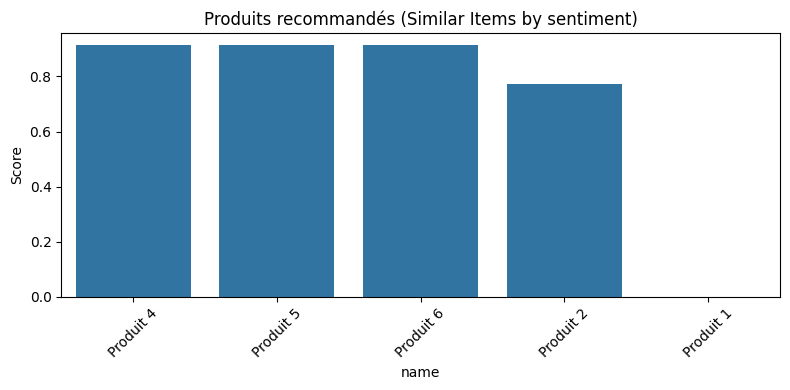

,product_id,name,category
0,4,Produit 4,Accessoires
1,5,Produit 5,Accessoires
2,6,Produit 6,Accessoires
3,2,Produit 2,Électronique
4,1,Produit 1,Électronique


In [4]:
# Calculate average sentiment for each product

sentiment_scores = comments.groupby(['product_id', 'user_id'])['sentiment_score'].mean()

# Step 2: Filter for (product_id, user_id) pairs with sentiment_score > 0
positive_pairs = sentiment_scores[sentiment_scores > 0].index

# Step 3: Filter original comments where both product_id and user_id match the positive pairs
# Convert MultiIndex to a DataFrame for merging
positive_df = pd.DataFrame(positive_pairs.tolist(), columns=['product_id', 'user_id'])

# Merge with original comments
positive_products = comments.merge(positive_df, on=['product_id', 'user_id'])

# Step 4: Drop 'comment' and 'sentiment_score' and add 'commented_positif' column
positive_products = positive_products.drop(columns=['comment', 'sentiment_score'])
positive_products['commented_positif'] = True
#print(positive_products)

user_item_matrix_comments = positive_products.pivot_table(index="user_id", columns="product_id", values="commented_positif", fill_value=0)

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_matrix_comments)

item_similarity_matrix_comments = cosine_similarity(user_item_matrix_comments.T)
item_similarity_df_comments = pd.DataFrame(item_similarity_matrix_comments, index=user_item_matrix_comments.columns, columns=user_item_matrix_comments.columns)
#print(user_item_matrix_comments)
#print(item_similarity_matrix_comments)
#print(item_similarity_df_comments)


# Recommandation basée sur sentiment des commentaires
def recommend_by_sentiment(user_id):
    user_ratings_comments = user_item_matrix_comments.loc[user_id]
    liked_items_comments = user_ratings_comments[user_ratings_comments == 1].index.tolist()
    #print(liked_items_comments)
    # Calculer les scores de similarité entre les produits appréciés par l'utilisateur
    item_scores_comments = item_similarity_df_comments[liked_items_comments].sum(axis=1)
    #print(item_scores)
    # Exclure les produits que l'utilisateur a déjà aimés
    item_scores_comments = item_scores_comments.drop(index=liked_items_comments, errors='ignore')
    print(item_scores_comments)
    return item_scores_comments


    
# Calcul des recommandations hybrides
final_recommendations3 = recommend_by_sentiment(user_id=1).sort_values(ascending=False).head(20)
recommended_products3 = products[products["product_id"].isin(final_recommendations3.index)][["product_id", "name", "category"]]
recommended_products3 = recommended_products3.set_index("product_id").loc[final_recommendations3.index].reset_index()


# Visualisation
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended_products3["name"], y=final_recommendations3.values)
plt.title("Produits recommandés (Similar Items by sentiment)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

recommended_products3

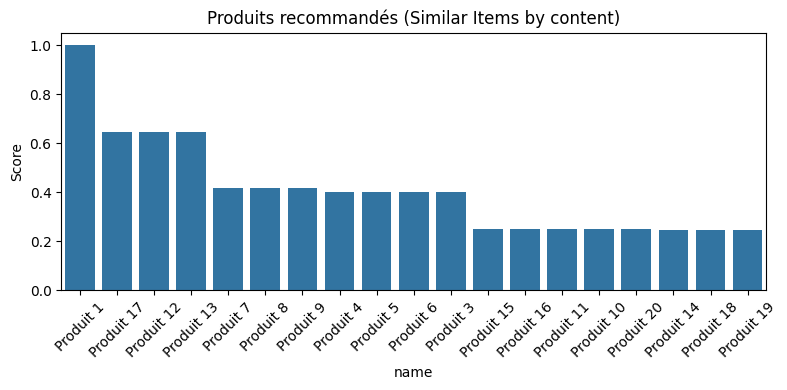

,product_id,name,category
0,1,Produit 1,Électronique
1,17,Produit 17,Électronique
2,12,Produit 12,Électronique
3,13,Produit 13,Électronique
4,7,Produit 7,Mode
5,8,Produit 8,Mode
6,9,Produit 9,Mode
7,4,Produit 4,Accessoires
8,5,Produit 5,Accessoires
9,6,Produit 6,Accessoires


In [5]:

# TF-IDF sur les descriptions de produits
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['description'])

# Matrice de similarité de contenu entre produits
content_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Transformer en DataFrame pour plus de clarté
content_similarity_df = pd.DataFrame(content_similarity_matrix, index=products["product_id"], columns=products["product_id"])




def recommend_by_content(user_id):
    user_ratings = user_item_matrix.loc[user_id]
    liked_items = user_ratings[user_ratings == 1].index.tolist()

    # Score total de similarité pour chaque produit par rapport à ceux aimés
    content_scores = content_similarity_df[liked_items].sum(axis=1)
    
    # Supprimer les produits déjà likés
    content_scores = content_scores.drop(index=liked_items, errors='ignore')

    return content_scores



    
# Calcul des recommandations hybrides
final_recommendations4 = recommend_by_content(user_id=1).sort_values(ascending=False).head(20)
recommended_products4 = products[products["product_id"].isin(final_recommendations4.index)][["product_id", "name", "category"]]
recommended_products4 = recommended_products4.set_index("product_id").loc[final_recommendations4.index].reset_index()


# Visualisation
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended_products4["name"], y=final_recommendations4.values)
plt.title("Produits recommandés (Similar Items by content)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

recommended_products4

[2]
product_id
1    0.000000
2    0.771517
4    0.912871
5    0.912871
6    0.912871
dtype: float64


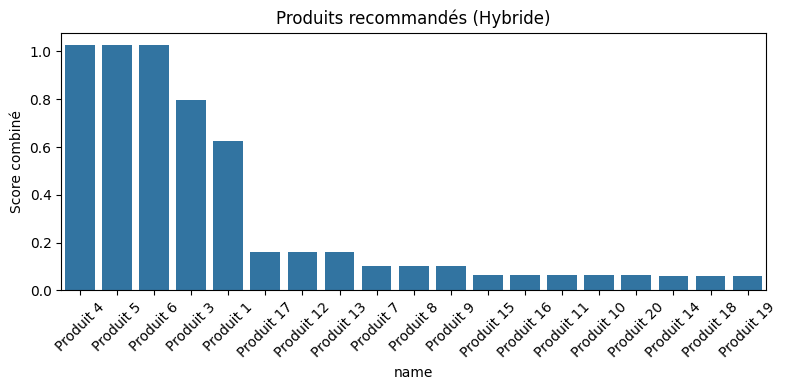

,product_id,name,category
0,4,Produit 4,Accessoires
1,5,Produit 5,Accessoires
2,6,Produit 6,Accessoires
3,3,Produit 3,Mode
4,1,Produit 1,Électronique
5,17,Produit 17,Électronique
6,12,Produit 12,Électronique
7,13,Produit 13,Électronique
8,7,Produit 7,Mode
9,8,Produit 8,Mode


In [6]:
def hybrid_recommendation(user_id, top_n=5, weight_user=0.25, weight_item=0.25, weight_sentiment=0.25, weight_content=0.25):
    user_based_scores = recommend_by_similar_users(user_id)
    item_based_scores = recommend_by_similar_items(user_id)
    sentiment_scores = recommend_by_sentiment(user_id)
    content_scores = recommend_by_content(user_id)

    combined_scores = (weight_user * user_based_scores).add(
        weight_item * item_based_scores, fill_value=0).add(
        weight_sentiment * sentiment_scores, fill_value=0).add(
        weight_content * content_scores, fill_value=0)

    liked_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 1].index.tolist()
    combined_scores = combined_scores.drop(index=liked_items, errors='ignore')

    return combined_scores.sort_values(ascending=False).head(top_n)


"""
# Fusion des trois approches
def hybrid_recommendation(user_id, top_n=5, weight_user=0.33, weight_item=0.33, weight_sentiment=0.34):
    user_based_scores = recommend_by_similar_users(user_id)
    item_based_scores = recommend_by_similar_items(user_id)
    sentiment_scores = recommend_by_sentiment(user_id)

    combined_scores = (weight_user * user_based_scores).add(
        weight_item * item_based_scores, fill_value=0).add(
        weight_sentiment * sentiment_scores, fill_value=0)

    liked_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 1].index.tolist()
    combined_scores = combined_scores.drop(index=liked_items, errors='ignore')

    return combined_scores.sort_values(ascending=False).head(top_n)"""
    
# Calcul des recommandations hybrides
final_recommendations = hybrid_recommendation(user_id=1, top_n=20)
recommended_products = products[products["product_id"].isin(final_recommendations.index)][["product_id", "name", "category"]]
recommended_products = recommended_products.set_index("product_id").loc[final_recommendations.index].reset_index()

# Visualisation
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended_products["name"], y=final_recommendations.values)
plt.title("Produits recommandés (Hybride)")
plt.ylabel("Score combiné")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

recommended_products

In [7]:

# ------------------------
# 🔍 Classification des utilisateurs par catégorie préférée
# ------------------------

# Join likes with product categories
likes_with_categories = user_likes.merge(products[['product_id', 'category']], on='product_id')

# Count the number of likes per user per category
category_counts = likes_with_categories.groupby(['user_id', 'category']).size().unstack(fill_value=0)

# Déterminer la catégorie préférée de chaque utilisateur
preferred_categories = category_counts.idxmax(axis=1)
users["preferred_category"] = users["user_id"].map(preferred_categories)

# Afficher les utilisateurs avec leur catégorie préférée
print("\n📊 Catégorie préférée de chaque utilisateur :")
print(users[["user_id", "username", "preferred_category"]])


📊 Catégorie préférée de chaque utilisateur :
   user_id username preferred_category
0        1    user1       Électronique
1        2    user2        Accessoires
2        3    user3        Accessoires
3        4    user4        Accessoires
4        5    user5        Accessoires
5        6    user6        Accessoires
6        7    user7       Électronique
7        8    user8       Électronique


In [8]:
# --- Évaluation avec precision et recall
from sklearn.model_selection import train_test_split

def create_train_test_split(user_likes_df):
    train_data = []
    test_data = []

    for user_id, group in user_likes_df.groupby("user_id"):
        if len(group) < 2:
            train_data.append(group)
            continue
        test_sample = group.sample(1)
        train_sample = group.drop(test_sample.index)
        test_data.append(test_sample)
        train_data.append(train_sample)

    train_df = pd.concat(train_data)
    test_df = pd.concat(test_data)
    return train_df, test_df

# Evaluation metrics
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    if not relevant:
        return 0.0
    return len(set(recommended_k) & set(relevant)) / len(relevant)

def evaluate_model(user_ids, k=5):
    precisions = []
    recalls = []

    for user_id in user_ids:
        recommended = hybrid_recommendation(user_id=user_id, top_n=k).index.tolist()
        relevant = test_likes[test_likes["user_id"] == user_id]["product_id"].tolist()

        if relevant:
            precisions.append(precision_at_k(recommended, relevant, k))
            recalls.append(recall_at_k(recommended, relevant, k))

    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0

    return avg_precision, avg_recall

# Step: Create train/test sets
train_likes, test_likes = create_train_test_split(user_likes)

# Rebuild the user-item matrix based on training data
user_item_matrix = train_likes.pivot_table(index="user_id", columns="product_id", values="liked", fill_value=0)
knn.fit(user_item_matrix)

# Evaluate
user_ids = user_item_matrix.index.tolist()
precision, recall = evaluate_model(user_ids, k=3)

print(f"Precision@3: {precision:.2f}")
print(f"Recall@3: {recall:.2f}")

[2]
product_id
1    0.000000
2    0.771517
4    0.912871
5    0.912871
6    0.912871
dtype: float64
[3, 4, 5, 6]
product_id
1    0.534522
dtype: float64
[2, 3, 4, 6]
product_id
1    0.534522
dtype: float64
[2, 3, 4, 5]
product_id
1    0.534522
dtype: float64
[2, 4, 5, 6]
product_id
1    0.534522
dtype: float64
[2, 3, 5, 6]
product_id
1    0.534522
dtype: float64
[1]
product_id
3    0.771517
4    0.845154
5    0.845154
6    0.845154
dtype: float64
[2]
product_id
3    0.771517
4    0.845154
5    0.845154
6    0.845154
dtype: float64
Precision@3: 0.29
Recall@3: 0.86


In [9]:
# --- Add tests for each recommendation type
"""
# Function to evaluate each recommendation type
def evaluate_recommendation_method(user_ids, method, k=3):
    precisions = []
    recalls = []

    for user_id in user_ids:
        recommended = method(user_id=user_id).index.tolist()
        relevant = test_likes[test_likes["user_id"] == user_id]["product_id"].tolist()

        if relevant:
            precisions.append(precision_at_k(recommended, relevant, k))
            recalls.append(recall_at_k(recommended, relevant, k))

    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0

    return avg_precision, avg_recall

# Create a dictionary to store results for each recommendation type
recommendation_methods = {
    "User-based": recommend_by_similar_users,
    "Item-based": recommend_by_similar_items,
    "Sentiment-based": recommend_by_sentiment,
    "Content-based": recommend_by_content,
    "Hybrid": hybrid_recommendation
}

# Evaluate each method
evaluation_results = {}

for method_name, method_func in recommendation_methods.items():
    precision, recall = evaluate_recommendation_method(user_ids, method_func, k=3)
    evaluation_results[method_name] = {"precision": precision, "recall": recall}


# --- Visualize the comparison results

# Prepare data for visualization
evaluation_df = pd.DataFrame(evaluation_results).T

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot precision
evaluation_df["precision"].plot(kind='bar', width=0.4, position=1, color='b', label="Precision", ax=ax)
# Plot recall
evaluation_df["recall"].plot(kind='bar', width=0.4, position=0, color='r', label="Recall", ax=ax)

ax.set_title("Comparison of Recommendation Methods: Precision & Recall")
ax.set_ylabel("Score")
ax.set_xlabel("Recommendation Type")
ax.set_xticklabels(evaluation_df.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()"""

'\n# Function to evaluate each recommendation type\ndef evaluate_recommendation_method(user_ids, method, k=3):\n    precisions = []\n    recalls = []\n\n    for user_id in user_ids:\n        recommended = method(user_id=user_id).index.tolist()\n        relevant = test_likes[test_likes["user_id"] == user_id]["product_id"].tolist()\n\n        if relevant:\n            precisions.append(precision_at_k(recommended, relevant, k))\n            recalls.append(recall_at_k(recommended, relevant, k))\n\n    avg_precision = np.mean(precisions) if precisions else 0.0\n    avg_recall = np.mean(recalls) if recalls else 0.0\n\n    return avg_precision, avg_recall\n\n# Create a dictionary to store results for each recommendation type\nrecommendation_methods = {\n    "User-based": recommend_by_similar_users,\n    "Item-based": recommend_by_similar_items,\n    "Sentiment-based": recommend_by_sentiment,\n    "Content-based": recommend_by_content,\n    "Hybrid": hybrid_recommendation\n}\n\n# Evaluate each

In [ ]:
from flask import Flask, jsonify, request, send_file, render_template_string

from flask_cors import CORS  # <-- Import CORS

app = Flask(__name__)
CORS(app)

@app.route('/api/recommend', methods=['GET'])
def recommend():
    try:
        user_id = int(request.args.get('user_id', 1))
        top_n = int(request.args.get('top_n', 5))

        rec_scores = hybrid_recommendation(user_id=user_id, top_n=top_n)
        recommended_products = products[products["product_id"].isin(rec_scores.index)][["product_id", "name", "category"]]
        recommended_products = recommended_products.set_index("product_id").loc[rec_scores.index].reset_index()

        result = recommended_products.to_dict(orient='records')
        return jsonify({"user_id": user_id, "recommendations": result})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# ✅ Important : évite le redémarrage automatique dans Jupyter
if __name__ == "__main__":
    #app.run(debug=True)
    app.run(use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [14/May/2025 19:51:08] "GET /api/recommend?user_id=1&top_n=5 HTTP/1.1" 200 -


[2]
product_id
1    0.000000
2    0.771517
4    0.912871
5    0.912871
6    0.912871
dtype: float64
